In [3]:
%matplotlib inline

In [4]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year
au_to_R_sun = (constants.au / constants.R_sun).value # conversion constant

In [6]:
# grab the formatted data 
data = ascii.read("data/visual_data_besselian.csv", format="csv", fill_values=[("X", '0')])

# convert years 
jds = Time(np.ascontiguousarray(data["epoch"]), format="byear").jd

In [7]:
data

<Table masked=True length=12>
  epoch   object   rho   rho_err    PA    PA_err   ref   
 float64  int64  float64 float64 float64 float64   str8  
--------- ------ ------- ------- ------- ------- --------
1992.0216      1     1.4      --   230.0      -- Rep1993b
  1998.14      1    1.44    0.01   215.4     1.0     none
 1998.496      1   1.469   0.001  216.11    0.03     none
 2003.136      1   1.481   0.003   213.4     0.5     none
 2004.143      1   1.477   0.006  215.78    0.09     none
2010.0698      1   1.526      --   208.9      -- Msn2018a
  2010.08      1   1.504   0.015   209.1     0.3 Jnn2014b
  2010.08      1   1.523   0.001   209.3     0.3  Jnn2012
2014.2646      1  1.5124  0.0181 207.387   0.687     none
 2014.303      1   1.544  0.0048  207.65    0.18     none
 2015.001      1   1.541      -- 207.165      -- Kpp2018m
2015.0277      1  1.5504  0.0007   207.1      -- Tok2015c

In [8]:
data["rho_err"][data["rho_err"].mask == True] = 0.05
data["PA_err"][data["PA_err"].mask == True] = 5.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns

rho_data = np.ascontiguousarray(data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(data["PA_err"] * deg) # radians

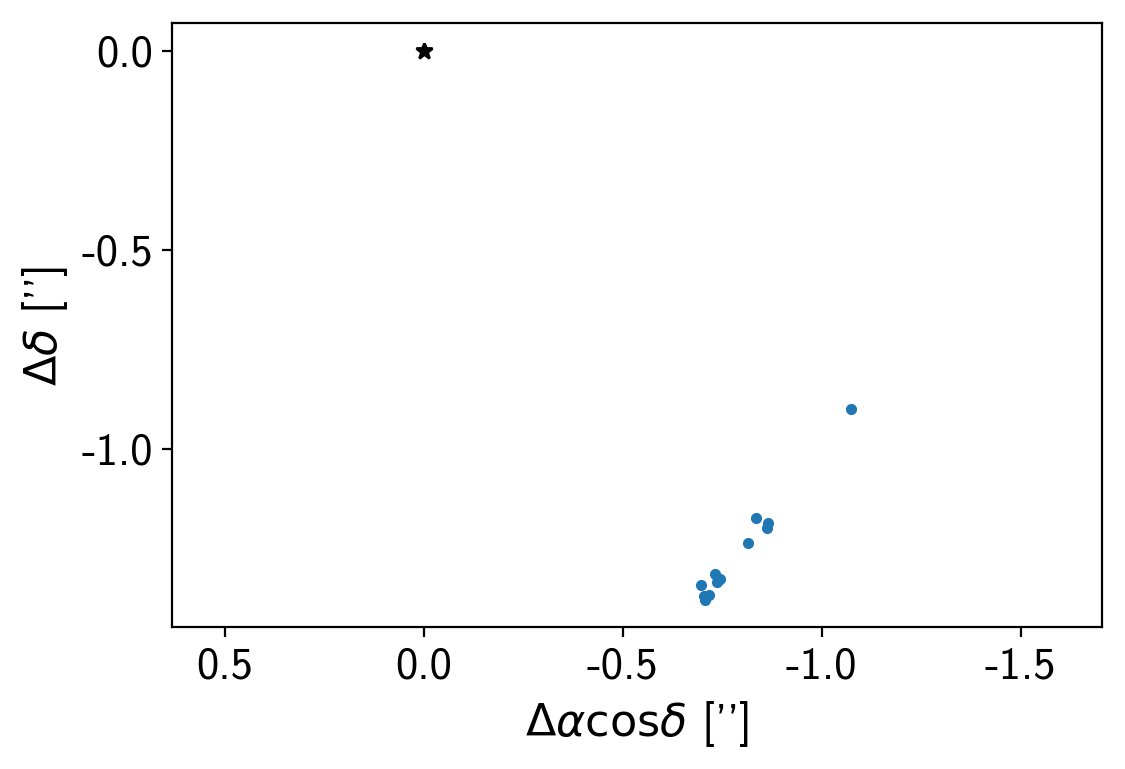

In [9]:
# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left

fig, ax = plt.subplots(nrows=1)

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

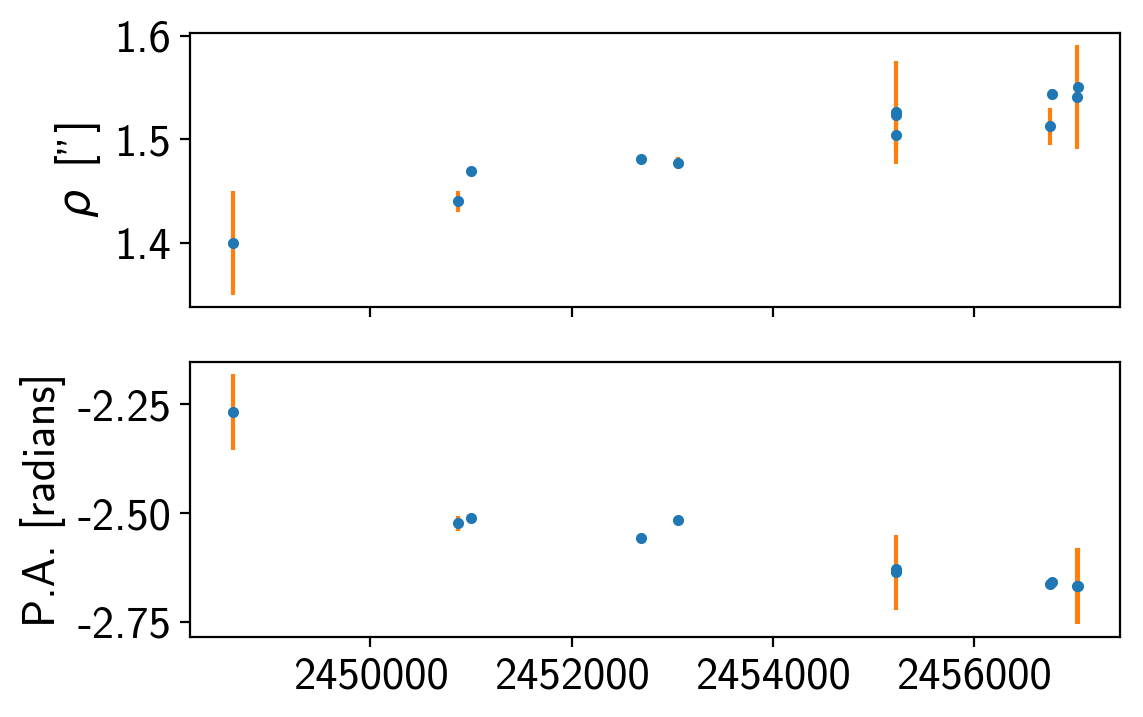

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(jds, rho_data, ".")
ax[0].errorbar(jds, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(jds, theta_data, ".")
ax[1].errorbar(jds, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

Load the Keck radial velocity data for A (gamma) and B.

We also need to make sure that we put the measurements onto the same scale, which, for now, is the CfA scale. So, we'll want to use the offset parameter we found from the spectroscopic binary fit to offset these to the same scale, or, ultimately use the ALMA scale and offset everything to that. In the hierarchical triple fit we'll want to keep everything consistent in the corrections.

For this fit, we're just going to use everything on the Keck scale.

We'll assume that the $\gamma$ velocity for A is the same at the average of the Keck epochs. Ultimately, $\gamma_A$ will become a function of $t$.



In [134]:
def get_arrays(asciiTable, errDict=None, jitter=False):
    """
    Reformat ascii tables into pure numpy arrays of the right dimension.
    """
    
    output = []
    
    star = "B"
    
    # get the RVs 
    rv = asciiTable["RV_" + star]

    if type(rv) is astropy.table.column.MaskedColumn:
        mask = ~rv.mask # values we want to keep when indexing
    else:
        mask = np.ones(len(rv), dtype="bool")

    rv = np.ascontiguousarray(rv[mask])
    date = np.ascontiguousarray(asciiTable["HJD"][mask]) + 2400000

    if errDict is None:
        err = np.ascontiguousarray(asciiTable["sigma_" + star][mask])
    else:
        err = np.ones(len(date), dtype=np.float64) * errDict[star]

    if jitter:
        err = np.ones(len(date), dtype=np.float64) * 0.4 # [km/s] assume a small error, since we'll infer.

    assert len(date) == len(rv), "date - rv length mismatch"
    assert len(date) == len(err), "date - err length mismatch"

    return (date, rv, err)
    
    
# Do this to infer w/ jitter 
jitter=True

data_keck = ascii.read("data/keck.dat", format="tab", fill_values=[("X", 0)])
err_keck = {"Aa":0.63, "Ab":0.85, "B":0.59} # km/s
keck_B = get_arrays(data_keck, err_keck, jitter=jitter)

# date is HJD + 2400000

keck_jd = np.average(keck_B[0])
keck_A_RV = 8.63 # [km/s] for now, use gamma from Kellogg solutions
keck_B_RV = np.average(keck_B[1])
keck_err = 0.4 # [km/s] guesstimate from average

In [22]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

In [23]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [136]:
# Set up the model in PyMC3

zeros = np.zeros_like(jds)
jd0 = jds[0]
t_fine = np.linspace(0, 1, num=500)
t_data = np.linspace(-yr, jds[-1] - jd0 + yr)

# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

xs_phase = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value 
    
    # 27.31 mas +/- 0.12 mas # from GAIA
    mparallax = pm.Normal("mparallax", mu=27.31, sd=0.12) # milliarcsec 
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 4.0, testval=2.0) # arcsec 
    
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax) # au
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Normal("logP", mu=np.log(400), sd=1.0)
    P = pm.Deterministic("P", tt.exp(logP) * yr) # days
    
    omega = Angle("omega", testval=1.8) # - pi to pi
    Omega = Angle("Omega", testval=-0.7) # - pi to pi
      
    phi = Angle("phi", testval=2.)
    
    n = 2*np.pi*tt.exp(-logP) / yr
    
    t_periastron = (phi + omega) / n
    
    cos_incl = pm.Uniform("cosIncl", lower=-1., upper=1.0, testval=np.cos(3.0))
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.3)
    gamma_keck = pm.Uniform("gammaKeck", lower=5, upper=10, testval=7.5) # km/s on Keck RV scale
    
    MB = pm.Normal("MB", mu=0.3, sd=0.5) # solar masses
        
    orbit = xo.orbits.KeplerianOrbit(a=a*au_to_R_sun, period=P, ecc=e, t_periastron=t_periastron, 
                                     omega=omega, Omega=Omega, incl=incl, m_planet=MB)
    
    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    MA = pm.Deterministic("MA", Mtot - MB)
    
    rho_model, theta_model = orbit.get_relative_angles(jds - jd0, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=2.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=2.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    
    # we need to calculate the difference 
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)
    
    # get the radial velocity predictions for primary and secondary 
    rvA = conv * orbit.get_star_velocity(keck_jd - jd0)[2] + gamma_keck
    rvB = conv * orbit.get_planet_velocity(keck_B[0] - jd0)[2] + gamma_keck
    
    # evaluate the RV likelihood functions
    pm.Normal("obs_A", mu=rvA, observed=keck_A_RV, sd=keck_err)
    pm.Normal("obs_B", mu=rvB, observed=keck_B[1], sd=keck_B[2])
    
    
    # save some samples on a fine orbit for plotting purposes
    t_period = pm.Deterministic("tPeriod", t_fine * P)
    
    rho, theta = orbit.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)
    
    rho, theta = orbit.get_relative_angles(t_data, parallax)
    rho_save_data = pm.Deterministic("rhoSaveData", rho)
    theta_save_data = pm.Deterministic("thetaSaveData", theta)
    
    
    # save RV plots
    t_dense = pm.Deterministic("tDense", xs_phase * P + jd0)
    rv1_dense = pm.Deterministic("RV1Dense", conv * orbit.get_star_velocity(t_dense - jd0)[2] + gamma_keck)
    rv2_dense = pm.Deterministic("RV2Dense", conv * orbit.get_planet_velocity(t_dense - jd0)[2] + gamma_keck)


In [137]:
with model:
    map_sol0 = xo.optimize(vars=[a_ang, phi])
    map_sol1 = xo.optimize(map_sol0, vars=[a_ang, phi, omega, Omega])
    map_sol2 = xo.optimize(map_sol1, vars=[a_ang, logP, phi, omega, Omega, incl, e])
    map_sol3 = xo.optimize(map_sol2)

optimizing logp for variables: ['phi_angle__', 'a_ang_interval__']
message: Optimization terminated successfully.
logp: -53915.986905182006 -> -9.529616719570951
optimizing logp for variables: ['Omega_angle__', 'omega_angle__', 'phi_angle__', 'a_ang_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -9.529616719570951 -> 96.1420837308422
optimizing logp for variables: ['e_interval__', 'cosIncl_interval__', 'Omega_angle__', 'omega_angle__', 'phi_angle__', 'logP', 'a_ang_interval__']
message: Optimization terminated successfully.
logp: 96.1420837308422 -> 102.16777497523701
optimizing logp for variables: ['logThetaS', 'logRhoS', 'MB', 'gammaKeck_interval__', 'e_interval__', 'cosIncl_interval__', 'phi_angle__', 'Omega_angle__', 'omega_angle__', 'logP', 'a_ang_interval__', 'mparallax']
message: Optimization terminated successfully.
logp: 102.16777497523701 -> 107.59389800405464


In [138]:
map_sol3["MA"]

array(0.18761341)

In [139]:
map_sol3["MB"]

array(0.50156995)

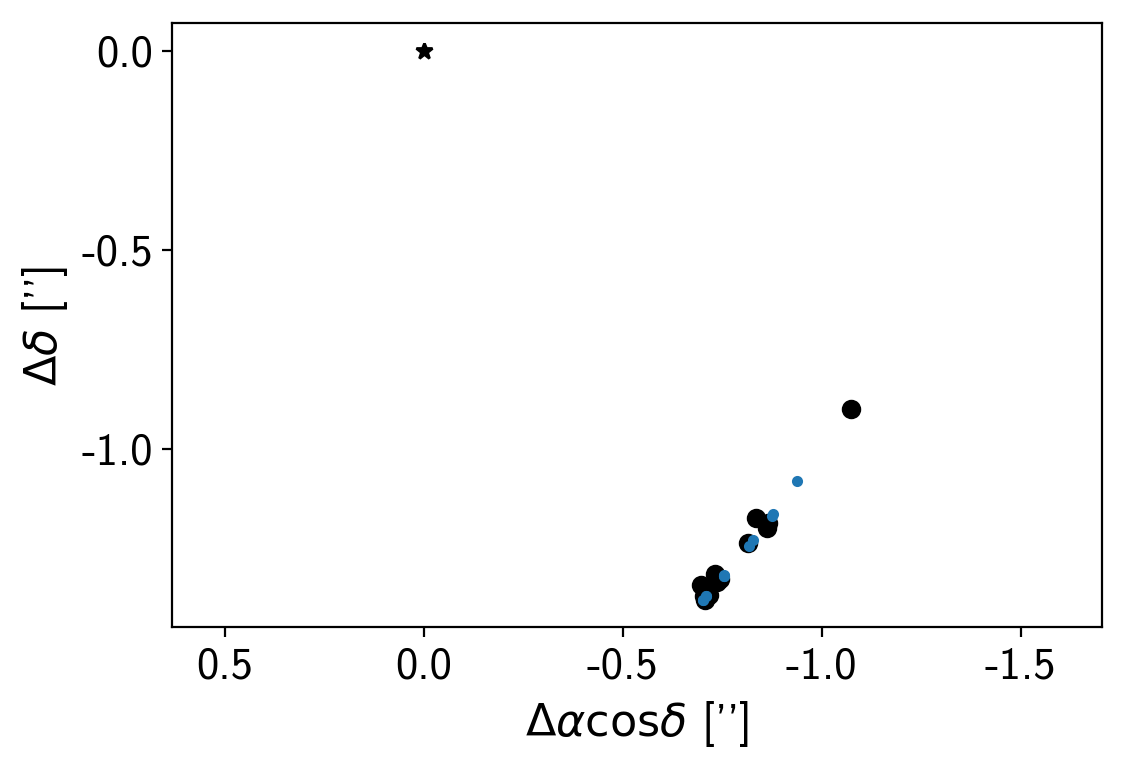

In [140]:
fig, ax = plt.subplots(nrows=1)

with model:
    rho = xo.eval_in_model(rho_model, map_sol3)
    theta = xo.eval_in_model(theta_model, map_sol3)

    
    # plot the data
    xs = rho_data * np.cos(theta_data) # X is north
    ys = rho_data * np.sin(theta_data) # Y is east
    ax.plot(ys, xs, "ko")

    
    # plot the orbit 
    xs = rho * np.cos(theta) # X is north
    ys = rho * np.sin(theta) # Y is east
    ax.plot(ys, xs, ".")


    ax.set_ylabel(r"$\Delta \delta$ ['']")
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
    ax.invert_xaxis()
    ax.plot(0,0, "k*")
    ax.set_aspect("equal", "datalim")

8.665253298443522 [7.41874412 7.41818986 7.38962924 7.38543621]


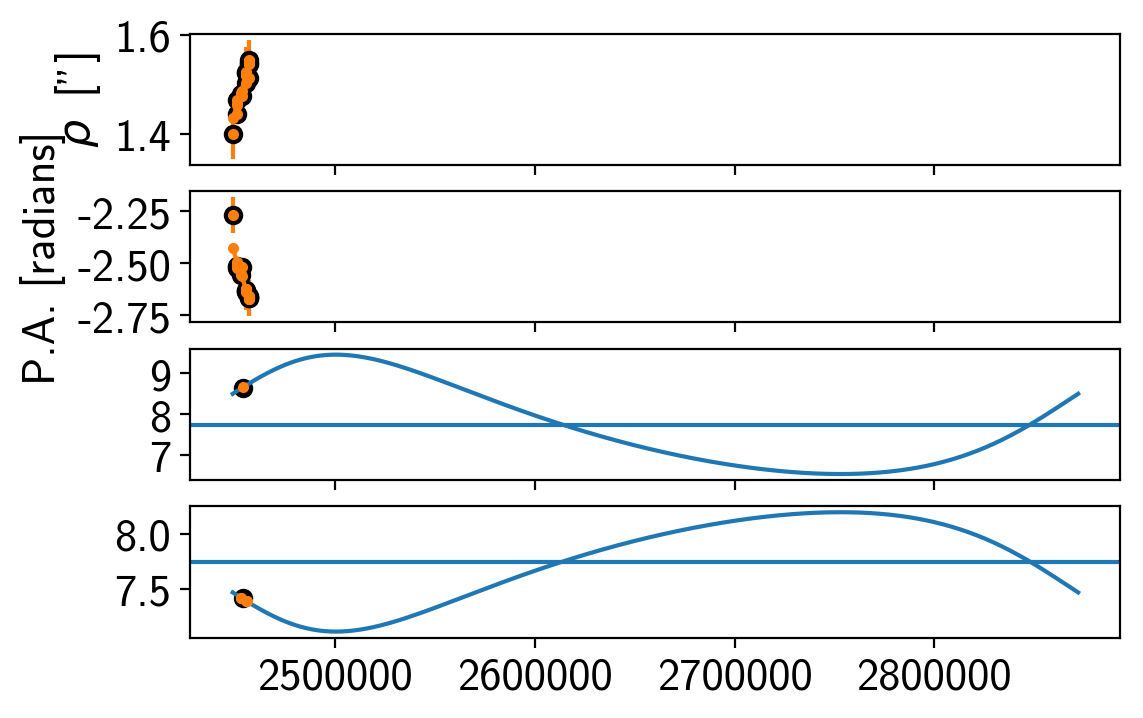

In [142]:
mkw = {"marker":".", "color":"C1"}

# pos = model.test_point
pos = map_sol3

with model:
    
    fig, ax = plt.subplots(nrows=4, sharex=True)

    ax[0].plot(jds, rho_data, "ko")
    ax[0].plot(jds, xo.eval_in_model(rho_model, pos), **mkw)
    ax[0].errorbar(jds, rho_data, yerr=rho_err, ls="", **mkw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(jds, theta_data, "ko")
    ax[1].plot(jds, xo.eval_in_model(theta_model, pos), **mkw)
    ax[1].errorbar(jds, theta_data, yerr=theta_err, ls="", **mkw)
    ax[1].set_ylabel(r'P.A. [radians]')

    model_A = xo.eval_in_model(rvA, pos)
    ax[2].axhline(pos["gammaKeck"])
    ax[2].plot(keck_jd, keck_A_RV, "ko")
    ax[2].plot(map_sol3["tDense"], map_sol3["RV1Dense"], color="C0")
    ax[2].plot(keck_jd, model_A, **mkw)
    

    model_B = xo.eval_in_model(rvB, pos)
    ax[3].axhline(pos["gammaKeck"])
    ax[3].plot(keck_jd, keck_B_RV, "ko")    
    ax[3].plot(map_sol3["tDense"], map_sol3["RV2Dense"], color="C0")
    ax[3].plot(keck_B[0], model_B, **mkw)
    print(model_A, model_B)


In [144]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=2000, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 408/408 [00:11<00:00, 36.18draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 808/808 [00:23<00:00,  9.17draws/s]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 1608/1608 [01:40<00:00,  4.23draws/s]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 2008/2008 [02:09<00:00,  2.75draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logThetaS, logRhoS, MB, gammaKeck, e, cosIncl, phi, Omega, omega, logP, a_ang, mparallax]
Sampling 4 chains: 100%|██████████| 12000/12000 [21:08<00:00,  3.11draws/s]
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The chain rea

In [145]:
pm.summary(trace)

mean             sd     mc_error       hpd_2.5  \
mparallax          27.309863       0.121210     0.001174     27.066282   
logP                6.438079       0.497788     0.012412      5.454594   
MB                  0.355211       0.497052     0.009761     -0.570007   
logRhoS            -4.819038       0.441138     0.005894     -5.750617   
logThetaS          -3.785912       0.304280     0.003388     -4.352135   
parallax            0.027310       0.000121     0.000001      0.027066   
a_ang               2.006880       0.574901     0.012861      1.053909   
a                  73.488473      21.060264     0.471457     38.432789   
P              257505.699593  129281.792822  3091.063956  66309.245800   
omega              -0.529979       1.476001     0.042457     -2.956808   
Omega               0.735899       1.088365     0.062525     -0.583783   
phi                 0.484578       0.806145     0.044225     -0.966779   
cosIncl            -0.696876       0.167947     0.003636     -0.982053   
incl                2.373412       0.249123     0.005459      1.919189   
e                   0.353333       0.210418     0.009690      0.000057   
gammaKeck           8.030222       0.814907     0.018033      6.350362   
Mtot                1.129537       1.164565     0.029819      0.218428   
MA                  0.774326       1.286244     0.035449     -0.840139   
tPeriod__0          0.000000       0.000000     0.000000      0.000000   
tPeriod__1        516.043486     259.081749     6.194517    132.884260   
tPeriod__2       1032.086972     518.163498    12.389034    265.768520   
tPeriod__3       1548.130458     777.245247    18.583551    398.652780   
tPeriod__4       2064.173945    1036.326997    24.778068    531.537040   
tPeriod__5       2580.217431    1295.408746    30.972585    664.421301   
tPeriod__6       3096.260917    1554.490495    37.167102    797.305561   
tPeriod__7       3612.304403    1813.572244    43.361619    930.189821   
tPeriod__8       4128.347889    2072.653993    49.556136   1063.074081   
tPeriod__9       4644.391375    2331.735742    55.750653   1195.958341   
tPeriod__10      5160.434862    2590.817491    61.945169   1328.842601   
tPeriod__11      5676.478348    2849.899241    68.139686   1461.726861   
...                      ...            ...          ...           ...   
RV2Dense__470       7.264470       0.971383     0.039566      5.428441   
RV2Dense__471       7.268147       0.947457     0.038589      5.463361   
RV2Dense__472       7.271849       0.923553     0.037611      5.483725   
RV2Dense__473       7.275570       0.899683     0.036634      5.537872   
RV2Dense__474       7.279306       0.875862     0.035657      5.590663   
RV2Dense__475       7.283052       0.852104     0.034681      5.635000   
RV2Dense__476       7.286805       0.828425     0.033706      5.687561   
RV2Dense__477       7.290560       0.804841     0.032732      5.719475   
RV2Dense__478       7.294313       0.781368     0.031760      5.799304   
RV2Dense__479       7.298061       0.758022     0.030789      5.858740   
RV2Dense__480       7.301798       0.734821     0.029821      5.870400   
RV2Dense__481       7.305524       0.711780     0.028855      5.923973   
RV2Dense__482       7.309234       0.688919     0.027892      5.954130   
RV2Dense__483       7.312927       0.666257     0.026933      5.996911   
RV2Dense__484       7.316599       0.643812     0.025977      6.068102   
RV2Dense__485       7.320250       0.621607     0.025024      6.108103   
RV2Dense__486       7.323877       0.599663     0.024076      6.191808   
RV2Dense__487       7.327479       0.578004     0.023133      6.202707   
RV2Dense__488       7.331056       0.556653     0.022194      6.248723   
RV2Dense__489       7.334606       0.535636     0.021260      6.250833   
RV2Dense__490       7.338129       0.514982     0.020332      6.297578   
RV2Dense__491       7.341623       0.494719     0.019410      6.343201   
RV2Dense__492       7.345089

/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3dfe4e80>,
      dtype=object)

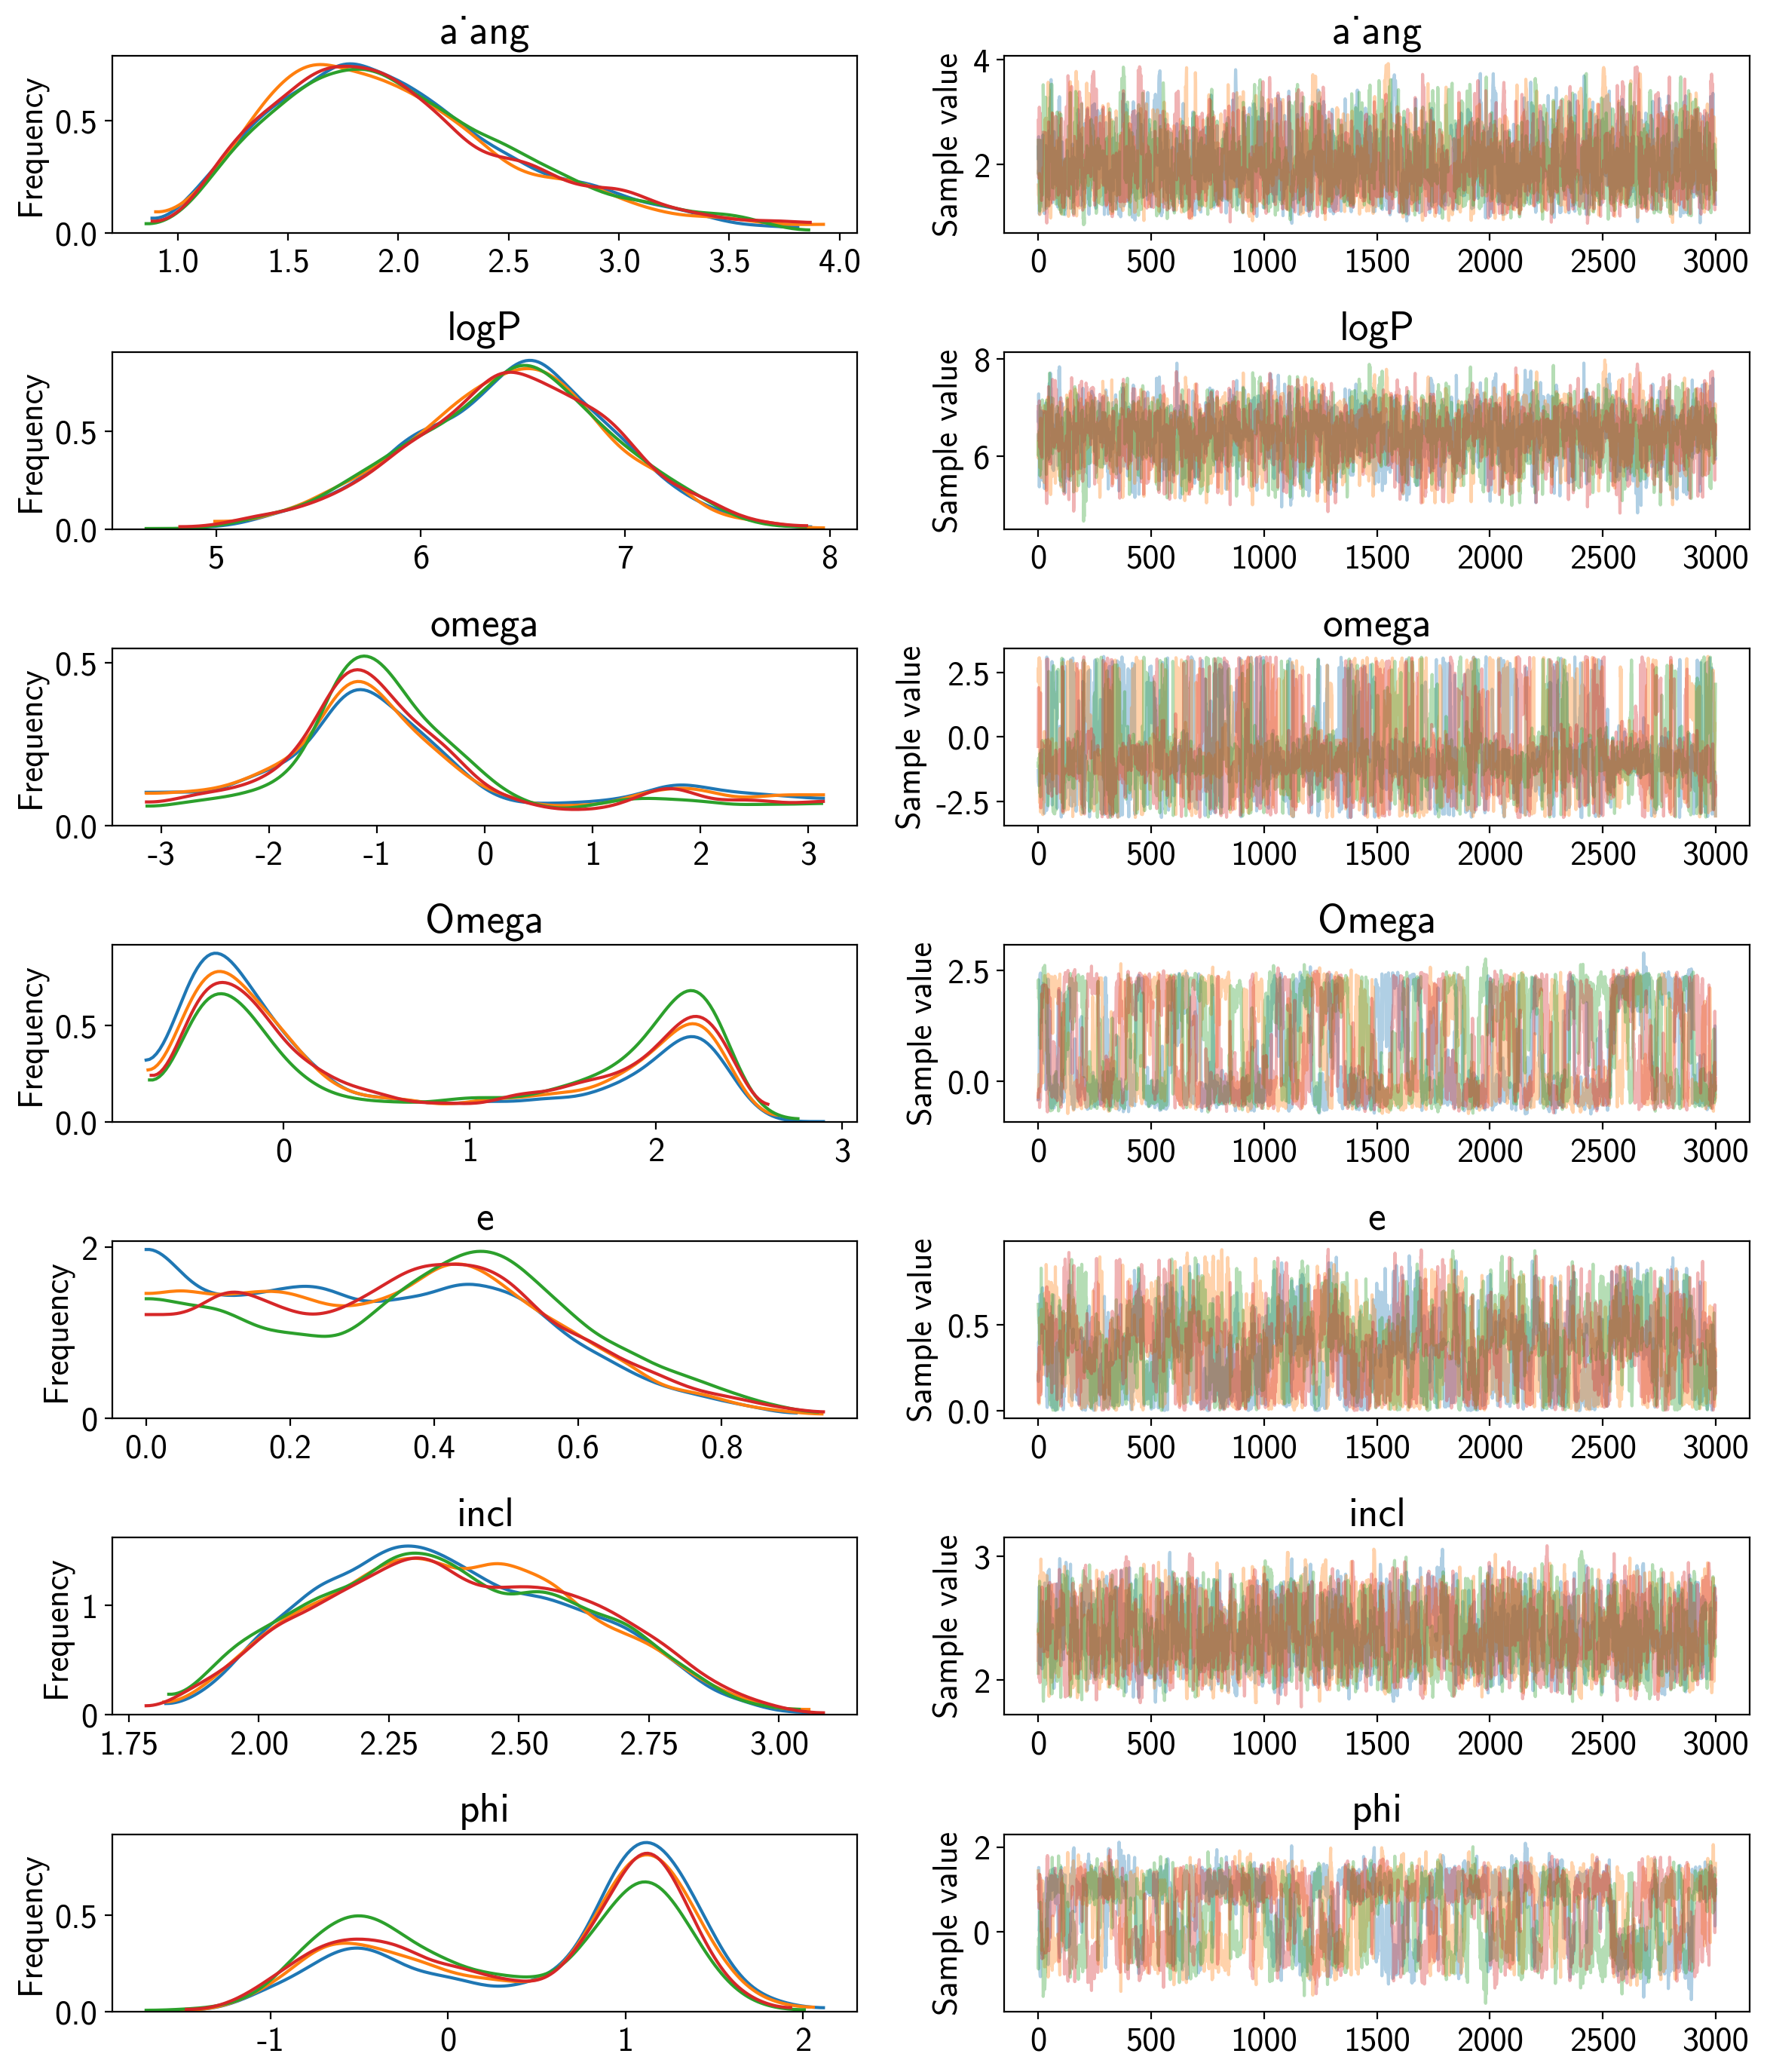

In [146]:
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "incl", "phi"])

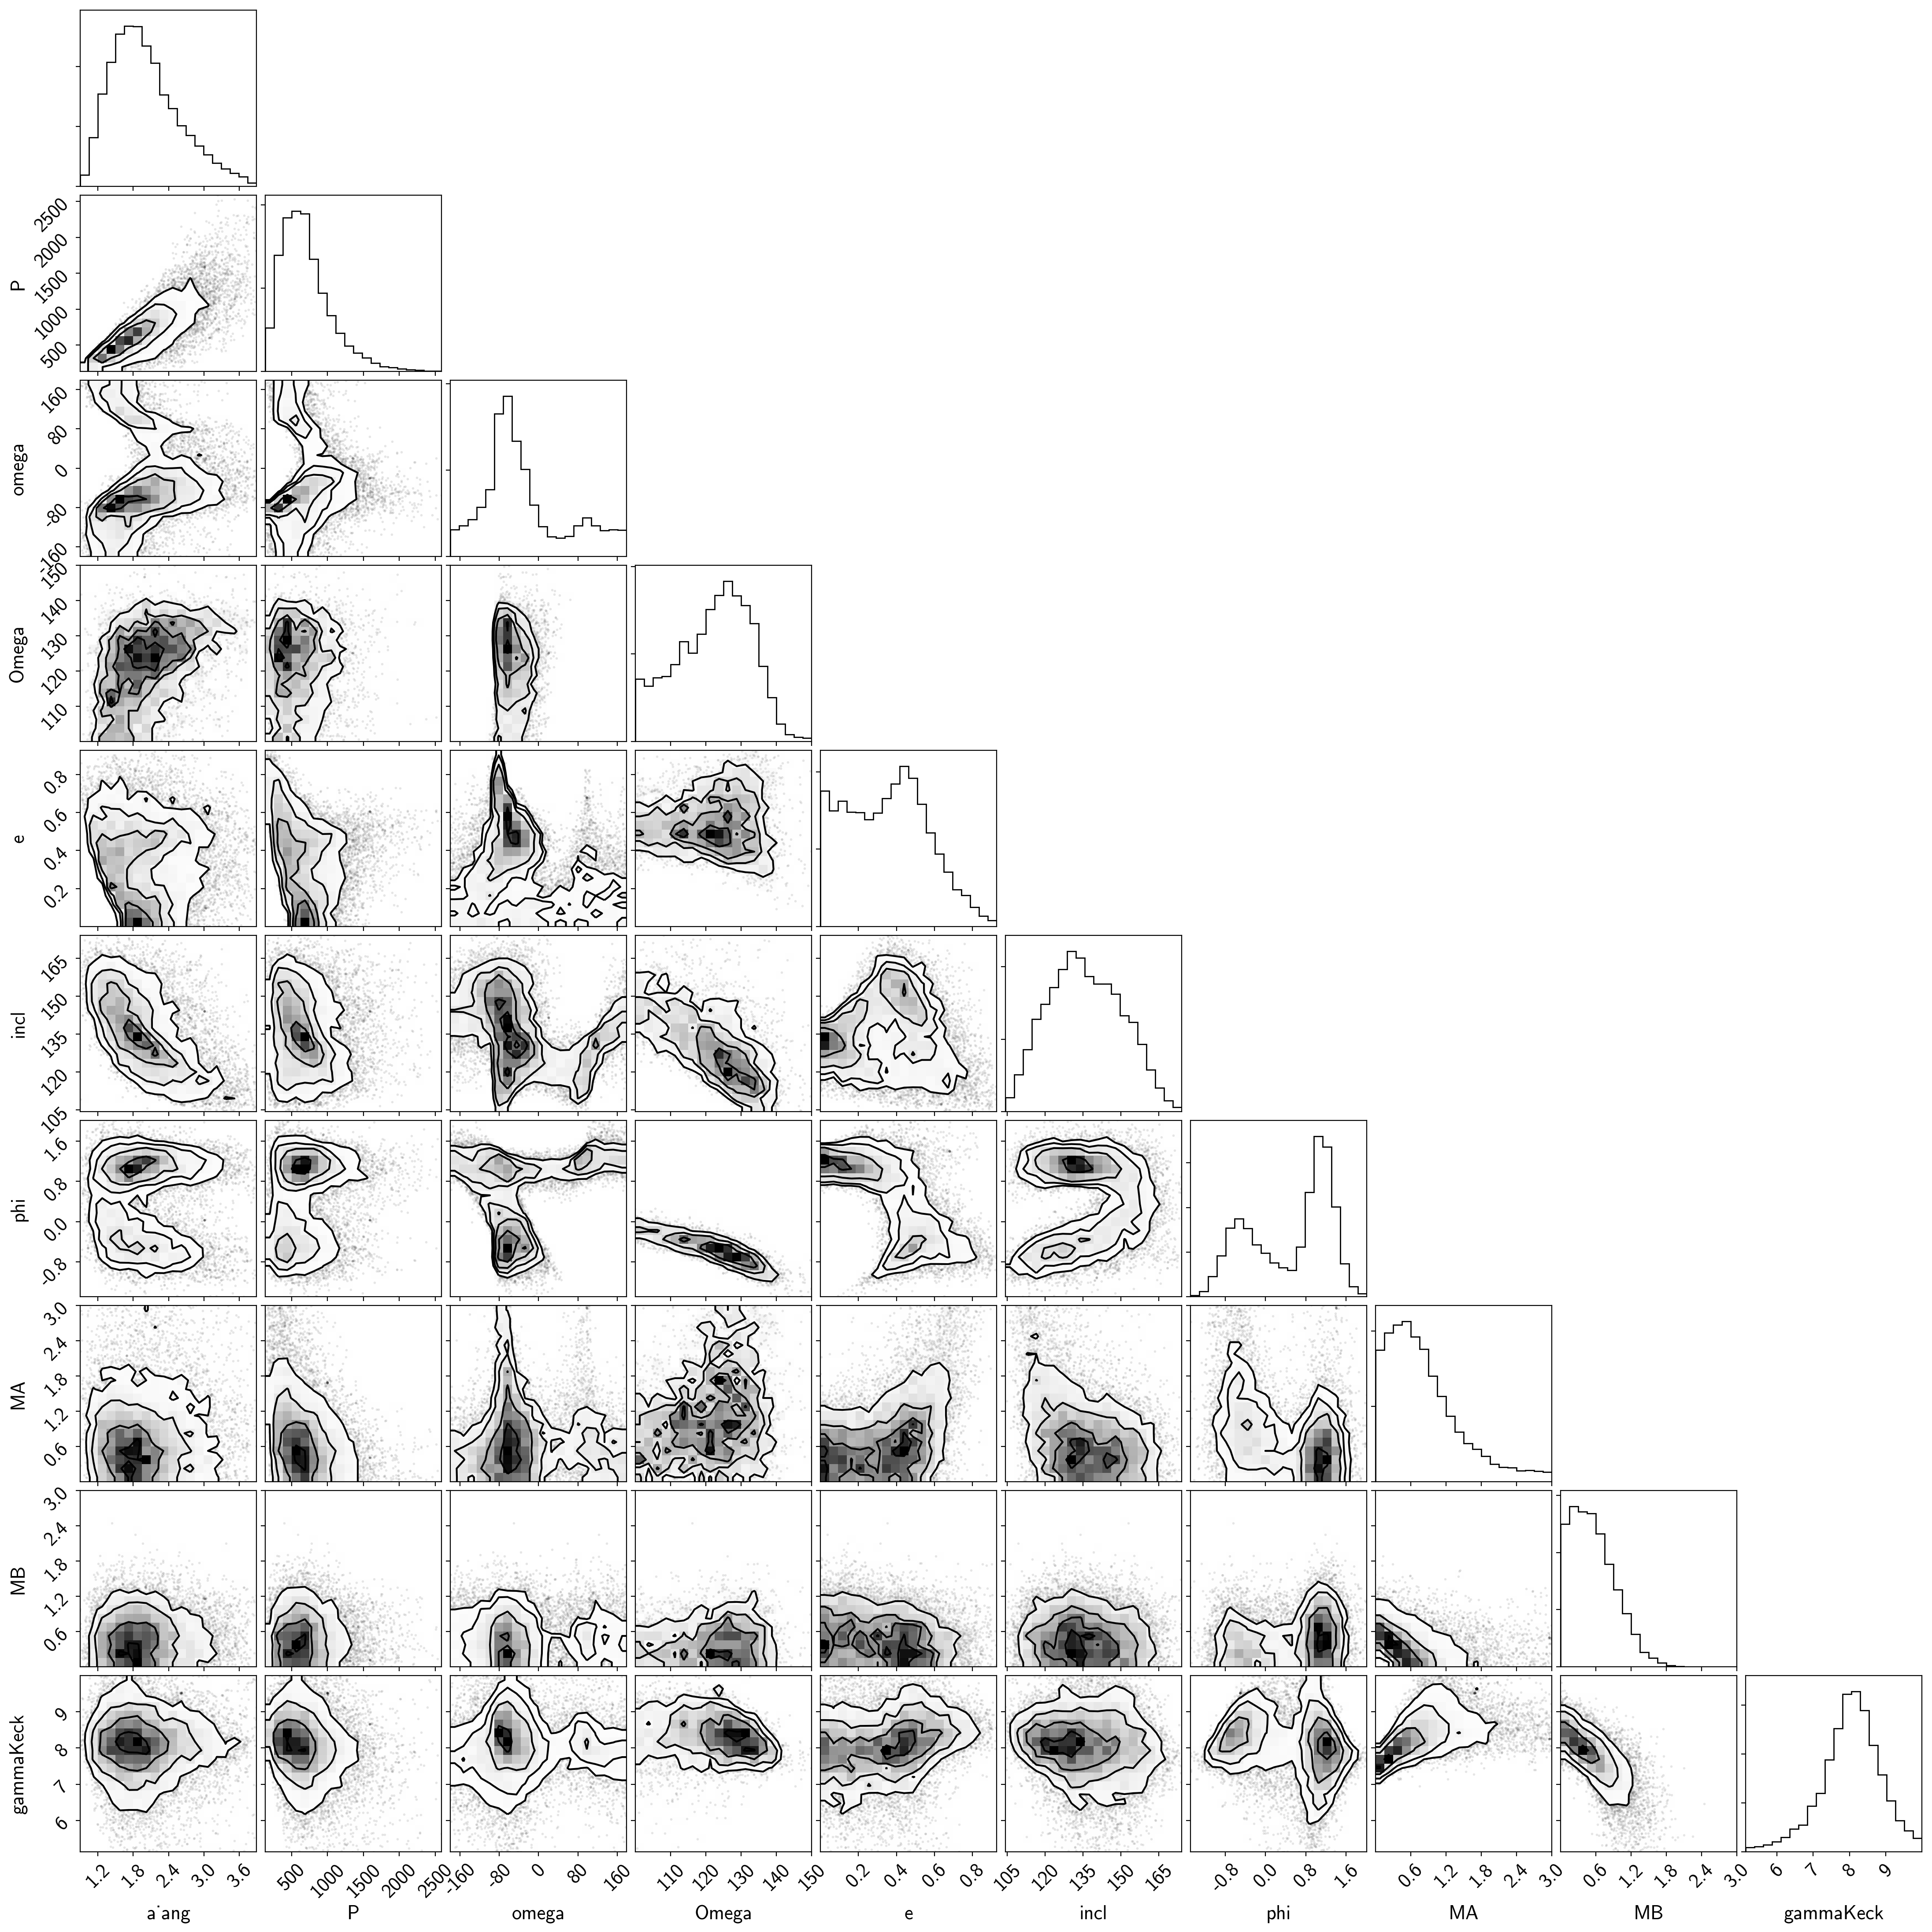

In [155]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["a_ang", "P", "omega", "Omega", "e", 
                                        "incl", "phi", "MA", "MB", "gammaKeck"])

samples["P"] /= yr
samples["omega"] /= deg
samples["Omega"] /= deg
samples["incl"] /= deg
f = 0.999
# corner.corner(samples, range=[f, f, f, [100, 150], f, f, f, [0, 3], [0, 3], f]);
corner.corner(samples, range=[f, f, f, f, f, f, f, [0, 3], [0, 3], f]);

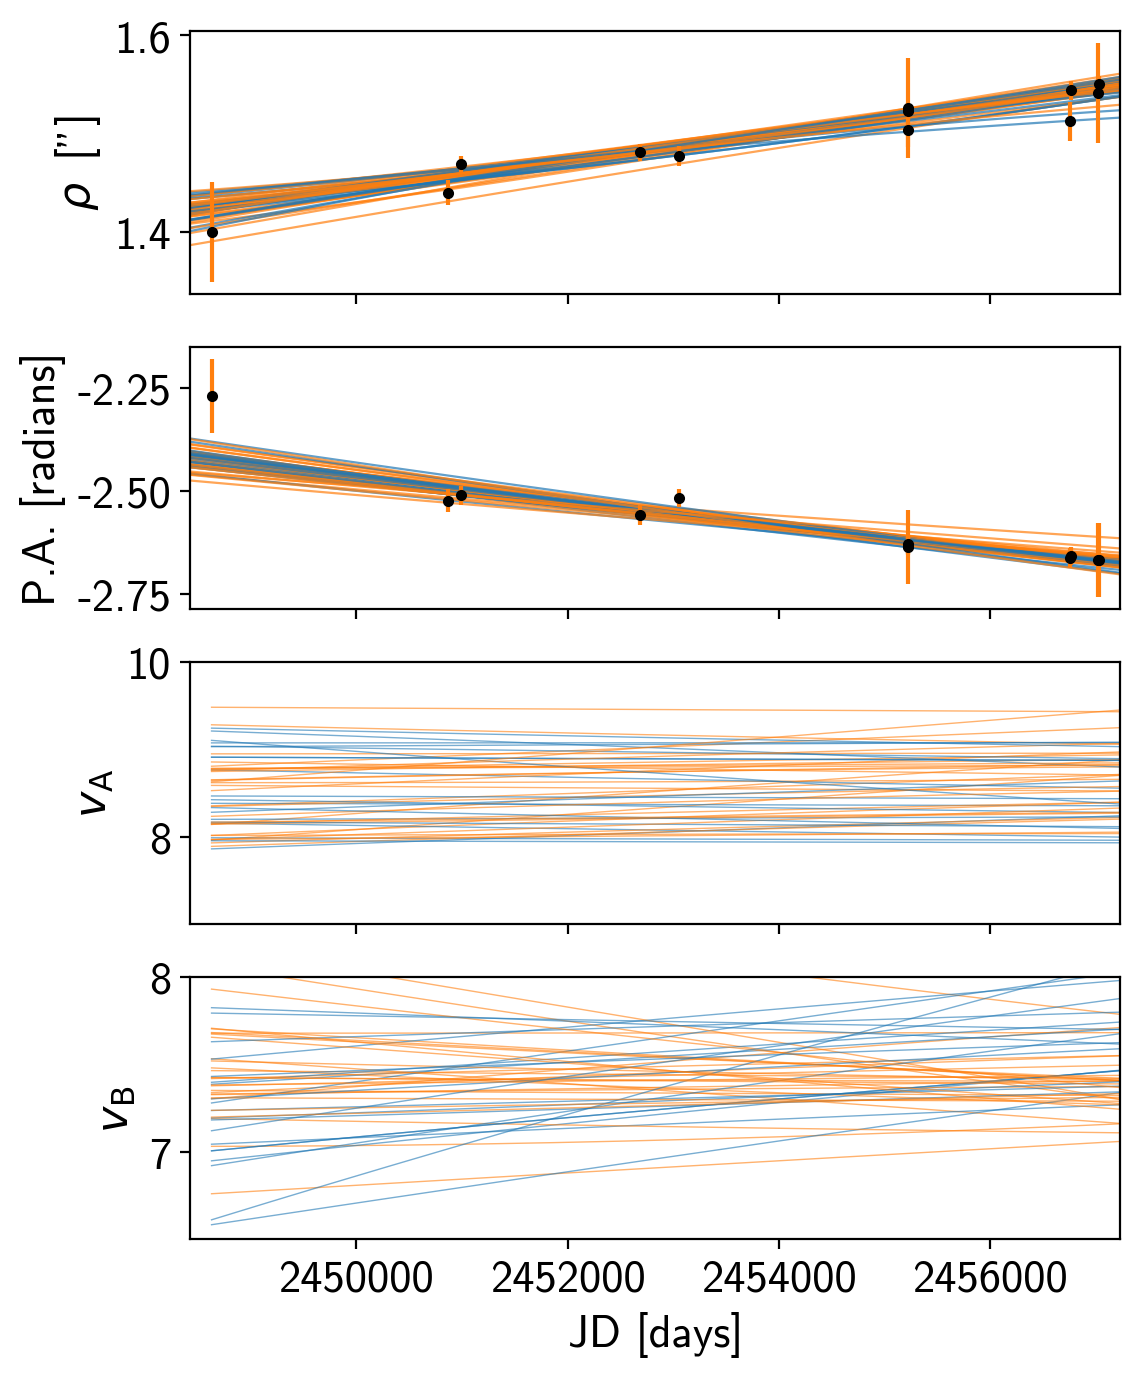

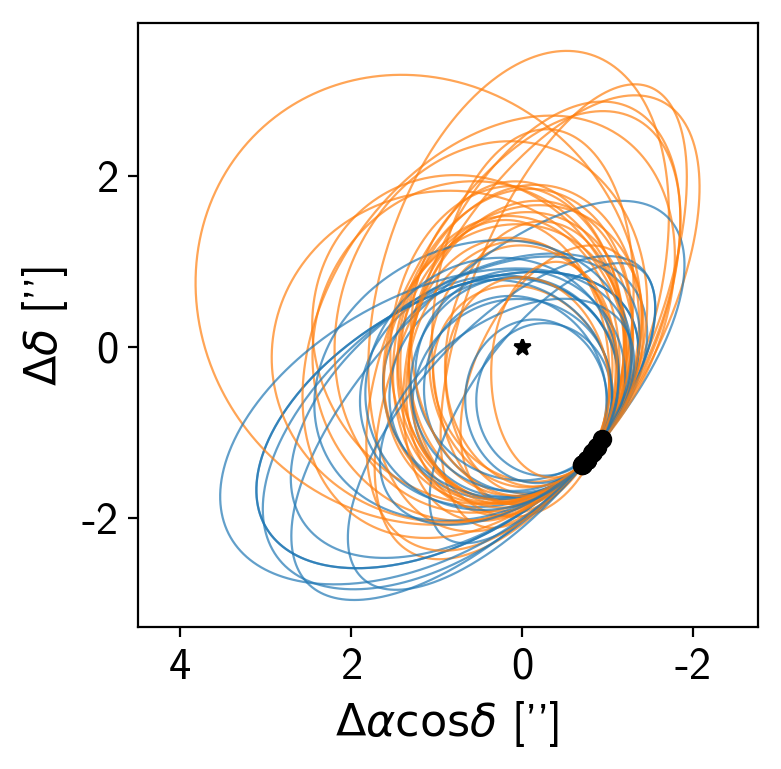

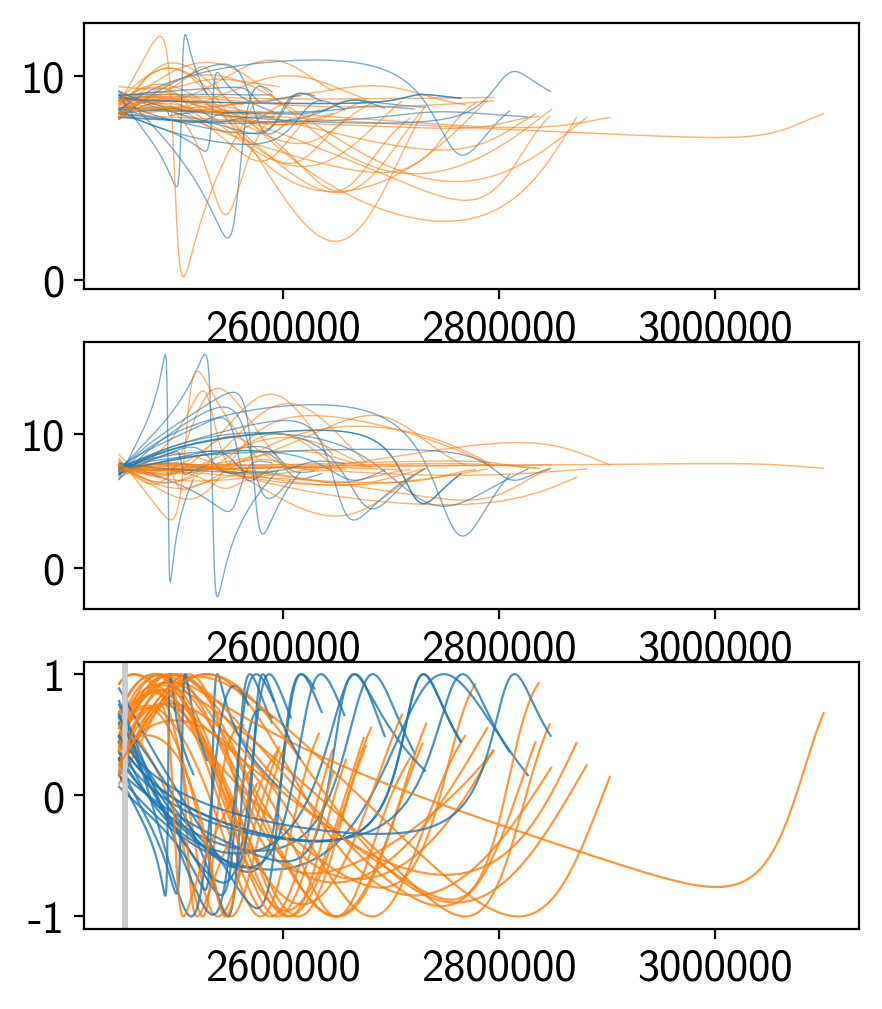

In [153]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')
ax[2].set_ylabel(r'$v_\mathrm{A}$')
ax[3].set_ylabel(r'$v_\mathrm{B}$')
ax[3].set_xlabel("JD [days]")    

nsamples = 50
choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

    
fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))
fig_phase, ax_phase = plt.subplots(nrows=3, figsize=(5,6))




with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
        
        # choose the color based upon Omega family 
        if pos["Omega"] > 50 * deg:
            color = "C0"
        else:
            color = "C1"
                
    
        t_pred = pos["tPeriod"]
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(jd0 + t_data, pos["rhoSaveData"], color=color, lw=0.8, alpha=0.7, zorder=0)
        ax[1].plot(jd0 + t_data, pos["thetaSaveData"], color=color, lw=0.8, alpha=0.7, zorder=0)
        
        ax[2].plot(pos["tDense"], pos["RV1Dense"], color=color, lw=0.5, alpha=0.6)
        ax[2].set_ylim(7, 10)
        
        ax[3].plot(pos["tDense"], pos["RV2Dense"], color=color, lw=0.5, alpha=0.6)
        ax[3].set_xlim(np.min(jds) - 200, np.max(jds) + 200)
        ax[3].set_ylim(6.5, 8)

        
        ax_phase[0].plot(pos["tDense"], pos["RV1Dense"], color=color, lw=0.5, alpha=0.6)
        ax_phase[1].plot(pos["tDense"], pos["RV2Dense"], color=color, lw=0.5, alpha=0.6)
        diff = pos["RV1Dense"] - pos["RV2Dense"] 
        max_amp = np.max(np.abs(diff))
        ax_phase[2].axvline(keck_jd, color="0.8")
        ax_phase[2].plot(pos["tDense"], diff / max_amp, lw=0.8, color=color, alpha=0.8)

        
        ax_sky.plot(y_pred, x_pred, color=color, lw=0.8, alpha=0.7)
        
        

ax[0].plot(jds, rho_data, **pkw, zorder=20)
ax[0].errorbar(jds, rho_data, yerr=tot_rho_err, **ekw, zorder=19)
    
ax[1].plot(jds, theta_data, **pkw, zorder=20)
ax[1].errorbar(jds, theta_data, yerr=tot_theta_err, **ekw, zorder=19)
    

ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")

It looks like all of the orbit families actually satisfy the constraint that `RV_A > RV_B`. So, to fully debug this, we would want to get the velocity of star B at the epoch corresponding to the node crossing, and make sure it's positive (receding). Then, we could get a sense of whether or not the RV point removed the degeneracy. 

Or, probably the coolest thing is to plot the separate orbit families of Omegas and see how both can still survive underneath the RV constraint.

I think having only one RV point is OK. Basically, there are two points on the orbit that have the same relative RV_A RV_B points. It's as you see the node ascending vs. descending that you begin to gain some resolution. If in fact the RV increase of B is significant, then I think this would favor one family of orbits over the other. 

I think a nice plot might be showing which orbits are favored with one set of constraints, then applying the next set of constraints, then further and further.

Given the trace, select all of the samples below/above omega. 

In [ ]:
pm.backends.ndarray.save_trace(trace, directory="may17", overwrite=True)